# Projet BD8: Apprentissage Supervisé
   ###  Mise en place d'un système de prédiction

## A - Exploration des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Importer les données de student-data.csv 
df= pd.read_csv("student-data.csv")
df.head()
df.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
passed        object
dtype: object

Note: toutes les colonnes sont des données sur les étudiants (prédicteurs possibles) sauf la dernière'passed' qui est la colone à prédir

### Statistiques sur l'échantillon:

In [2]:

nbr_etudiants = df.shape[0]
nbr_caract = df.shape[1] - 1
nbr_passe = df[df['passed'] == 'yes'].shape[0]
nbr_echoue = df[df['passed'] == 'no'].shape[0]
taux_grad = float(nbr_passe*1.0 / nbr_etudiants*1.0)*100
print ("Taille de l'échantillon (étudiants): {}".format(nbr_etudiants))
print ("Nombre d'étudiants réussi: {}".format(nbr_passe))
print ("Nombre d'étudiants échoué: {}".format(nbr_echoue))
print ("Nombre de caractéristiques: {}".format(nbr_caract))
print ("Taux de graduation: {:.3f}%".format(taux_grad))

Taille de l'échantillon (étudiants): 395
Nombre d'étudiants réussi: 265
Nombre d'étudiants échoué: 130
Nombre de caractéristiques: 30
Taux de graduation: 67.089%


# B - Préparation des données :

### 1. Identifier les features/prédicteurs et la colonne cible 

On remarque bien qu'on a des données non numéeriques.Pour pouvoir developper des modeles d'apprentissage automatique, on doit convertir ces données en numériques, sur lesquelles les algorithmes peuvent effectuer des calculs. Sinon, soit on se limite au données numériques, ou au peu d'algorithme capable de manipuler toutes les données et qui ne sont pas forcément les meilleurs.

Séparation des colonnes caractéresant l'echantillon(features) et cible (target = 'passed') l'étiquette à prédire 
Séparons d'abord nos données en colonnes d'objet et de cible, et voyons si des fonctionnalités sont non numériques.
Remarque: Pour ce jeu de données, la dernière colonne ('passed') est la cible ou l'étiquette que nous essayons de prédire.

passed
no     6.761538
yes    5.192453
Name: absences, dtype: float64

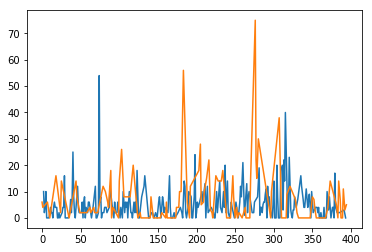

In [3]:
#Commencant par la colone cible 'passed' 

%matplotlib inline

df[df['passed'] == 'yes']['absences'].plot(x='étudiant', y='Nombre d"absences')
df[df['passed'] == 'no']['absences'].plot(x='étudiant', y='Nombre d"absences' )
df.groupby("passed")['absences'].mean()


passed
no     3.684615
yes    3.490566
Name: health, dtype: float64

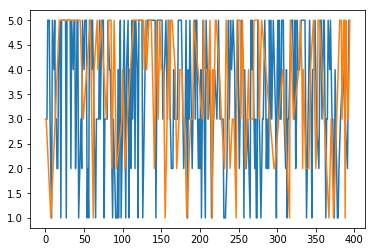

In [4]:
%matplotlib inline
df[df['passed'] == 'yes'] ['health'].plot()
df[df['passed'] == 'no'] ['health'].plot()
df.groupby("passed")['health'].mean()

In [5]:
# Séparer les Colonnes caractéristiques (feature: X) et la cible (target:y) 
caract_cols = list(df.columns[:-1])  # toutes les colonnes sauf passed
cible_col = df.columns[-1]  # la dernière colonne est la cible
print ("Colonnes des caractéristiques): \n{}".format(caract_cols))
print ("\nColonne cible: {}".format(cible_col))

X = df[caract_cols]  
Y = df[cible_col]  
print ("\nValeurs des caractéristiques:")
X.head()
print ("\nValeurs de la cible:")
Y.head()

Colonnes des caractéristiques): 
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Colonne cible: passed

Valeurs des caractéristiques:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,4
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,4



Valeurs de la cible:


0     no
1     no
2    yes
3    yes
4    yes
Name: passed, dtype: object


### 2. Effectuer un prétraitement sur les colonnes featured

A cette étape, on converti les valeurs non_numérique en valeurs numérique. Pour les colonnes ayant des valeurs OUI/NON ou autres deux valeurs possible, il est evident qu'elle soit converti en binaire 0/1. 

Quand les valeurs des colonnes dépasse deux, on génere autant de colonnes que de valeurs des variables, puis attribuer 1 a la premiere et 0 aux autres. On utilise la fonction pandas.get_dummies () pour effectuer cette transformation:
Exemple: la colonne "Mjob" qui a pour valeurs : 'at_home', 'health', 'other', 'services', 'teacher' donne aprés la transformation les cinq colonnes : 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher'

In [6]:
from IPython.display import display
# Preprocess feature columns
def pretraitement_colonnes(X):
    outX = pd.DataFrame(index=X.index)  # initilisation d'un dataframe de sortie
    # pour chaque colonne
    for col, col_data in X.iteritems():
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # ex: 'reason' =>'reason_course', 'reason_home', 'reason_other'
        outX = outX.join(col_data)
    return outX

X_converti = pretraitement_colonnes(X)
Y_converti = Y.replace(['yes', 'no'], [1, 0]) 
print ("Prétraitement des colonnes ({}):-\n{}".format(len(X_converti.columns), list(X_converti.columns)))
print ("\nValeurs des caractéristiques après conversion:")
X_converti.head()
print ("\nValeurs de la cible après conversion:")
Y_converti.head()

Prétraitement des colonnes (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Valeurs des caractéristiques après conversion:


,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1,0,1,0,18,0,1,1,0,1,...,1,0,0,4,3,4,1,1,3,6
1,1,0,1,0,17,0,1,1,0,0,...,1,1,0,5,3,3,1,1,3,4
2,1,0,1,0,15,0,1,0,1,0,...,1,1,0,4,3,2,2,3,3,10
3,1,0,1,0,15,0,1,1,0,0,...,1,1,1,3,2,2,1,1,5,2
4,1,0,1,0,16,0,1,1,0,0,...,1,0,0,4,3,2,1,2,5,4



Valeurs de la cible après conversion:


0    0
1    0
2    1
3    1
4    1
Name: passed, dtype: int64

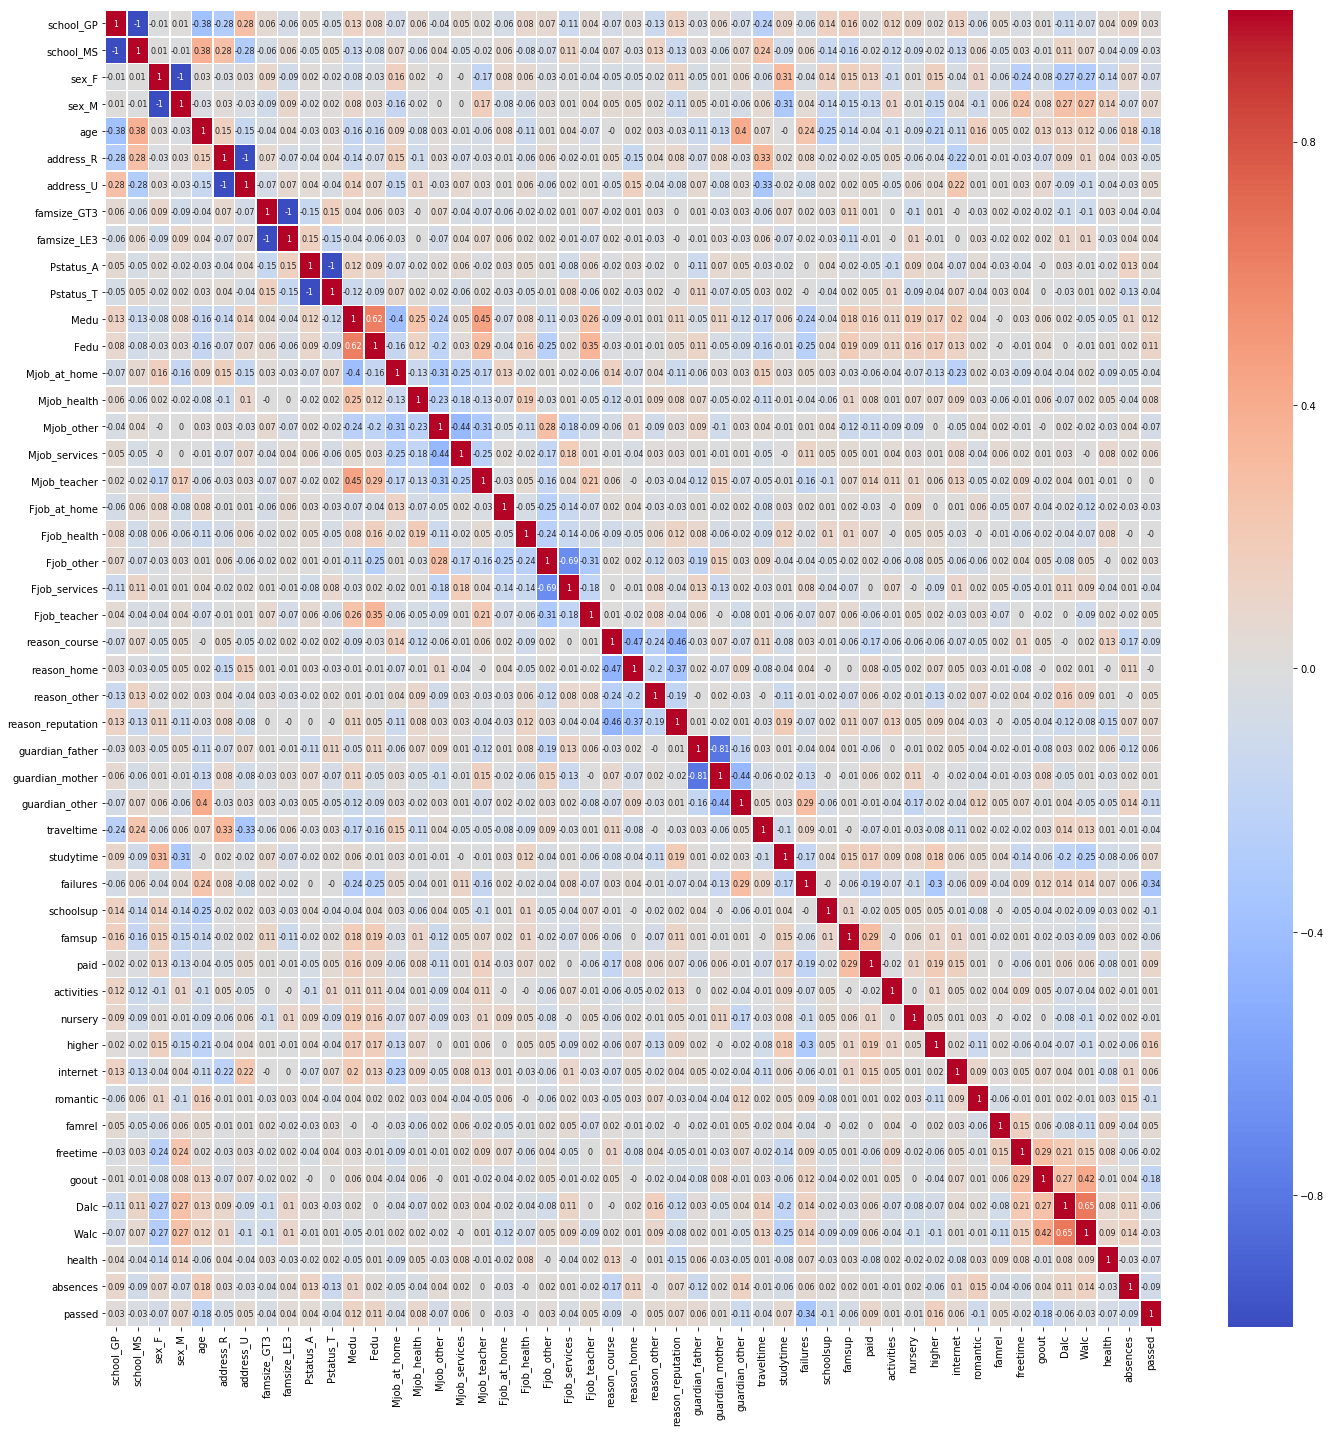

In [7]:
import seaborn as sns
#We can visualise the correlation between all the variables in the dataset using a heatmap in Seaborn

df_converti =  pd.concat([X_converti,Y_converti], axis=1)
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(data=df_converti.corr().round(2), cmap='coolwarm', annot=True, annot_kws={"size":8},linewidths=.5, ax=ax)
plt.tight_layout()
plt.show()


### 3. Partager les données en training et test

Après avoir convertir les colonnes catégorielles en valeurs numériques, on divise notre echantillo de donées en deux partie, données d'apprentissage (training) et données de test (80% - 20%).

In [8]:
df.shape[0]

395

In [16]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  X_converti, Y_converti, test_size=0.20, train_size = 0.80, random_state=42)
#detail de chacun des sous-dataset
print ("Ensemble d'apprentissage: {}".format(X_train.shape[0]))
print ("Ensemble de test: {} ".format(X_test.shape[0]))


Ensemble d'apprentissage: 316
Ensemble de test: 79 


## C. Modèle d’apprentissage et test évaluation :

  Après avoir choisir quelque modèles d'apprentissage supervisés disponibles dans scikit-learn, notre choix justifié va être consolider par des statistiques et mesures de performance. La compexité en terme du temps et espace mémoire, sur l'ensemble de test et d'apprentissage, le score F1 vont être l'objet de comparaison entre differents modèles d'une part et entre les trois tailles du training set (100,200,300)


In [10]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    return f1_score(target.values, y_pred, pos_label=1), end - start

In [11]:
# Train a model
import time

def train_classifier(clf, x_train, y_train):
    start = time.time()
    clf.fit(x_train, y_train)
    end = time.time()

    return end - start

In [12]:
# TODO: Train and predict using two other models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier

methodeClassification = [KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), ExtraTreesClassifier(),GaussianNB(), SVC()]
resultats = { 'Classifier': [], 'Size': [], 'Train time': [], 'predict time': [], 'F1 score - train': [],'F1 score - test': [] }

datasets = [train_test_split(X_converti, Y_converti, train_size=x, test_size=s) for [x,s] in [[100,95],[200,95],[316,79]]]                                                                                        

for clf in methodeClassification:
    for data in datasets:
        x_train, x_test, y_train, y_test = data
        time_train = train_classifier(clf, x_train, y_train)
        f1_train, time_predict = predict_labels(clf, x_train, y_train)
        f1_test, time_predict = predict_labels(clf, x_test,y_test)
        
        resultats['Classifier'].append(clf.__class__.__name__)
        resultats['Size'].append(x_train.shape[0])
        resultats['Train time'].append("{:.3f}".format(time_train))
        resultats['predict time'].append("{:.3f}".format(time_predict))
        resultats['F1 score - train'].append(f1_train)
        resultats['F1 score - test'].append(f1_test)
        
pd.DataFrame(resultats)

,Classifier,F1 score - test,F1 score - train,Size,Train time,predict time
0,KNeighborsClassifier,0.786667,0.848101,100,0.000,0.000
1,KNeighborsClassifier,0.759124,0.863014,200,0.000,0.000
2,KNeighborsClassifier,0.767857,0.867925,316,0.000,0.015
3,DecisionTreeClassifier,0.699187,1.000000,100,0.000,0.000
4,DecisionTreeClassifier,0.714286,1.000000,200,0.000,0.000
5,DecisionTreeClassifier,0.709091,1.000000,316,0.000,0.000
6,ExtraTreesClassifier,0.682171,1.000000,100,0.047,0.000
7,ExtraTreesClassifier,0.708661,1.000000,200,0.016,0.000
8,ExtraTreesClassifier,0.733945,1.000000,316,0.047,0.000
9,GaussianNB,0.710744,0.781955,100,0.000,0.000


# 5. Choix du meilleur modèle : 

In [15]:
from sklearn import grid_search
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.svm import SVC

cv = StratifiedShuffleSplit(Y_train, random_state=42)

clf = SVC()
param_grid = [
  {'C': [1, 10, 100, 200, 300, 400, 500, 600, 700],
   'gamma': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
   'kernel': ['rbf'], 'tol':[1e-3, 1e-4, 1e-5, 1e-6] } ]

regressor = grid_search.GridSearchCV(clf, param_grid,cv=cv, scoring='f1_weighted')
regressor.fit(X_train, y_train)
reg = regressor.best_estimator_
reg
train_f1_score = predict_labels(reg, X_train, y_train)

"Le score F1 pour l'ensemble d'apprentissage: {}".format(train_f1_score)

"Le score F1 pour l'ensemble de test {}".format(predict_labels(reg, X_test, y_test))

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\usager\Anaconda3\lib\site-packages\sklearn\metr

GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 1 ... 1 1], n_iter=10, test_size=0.1, random_state=42),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 200, 300, 400, 500, 600, 700], 'gamma': [0.01, 0.001, 0.0001, 1e-05, 1e-06], 'kernel': ['rbf'], 'tol': [0.001, 0.0001, 1e-05, 1e-06]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=0)

SVC(C=600, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

"Le score F1 pour l'ensemble d'apprentissage: (0.8477366255144033, 0.007481575012207031)"

"Le score F1 pour l'ensemble de test (0.7768595041322315, 0.08851146697998047)"